Predicting UP IR flux, large errors from rough calculation

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DS_a = xr.open_dataset('af') #dataset of auxhist
DS_w = xr.open_dataset('wf') #dataset of wrfout

In [3]:
#Temperature:
T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
T.shape

(71, 52, 36, 72)

In [4]:
T[5,:,18,0] #temperature goes from lowest hieght to highest hieght

array([242.71082 , 237.8069  , 236.24007 , 235.12848 , 234.2799  ,
       233.52779 , 232.82172 , 232.14073 , 231.47406 , 230.81564 ,
       229.99742 , 229.01949 , 228.03973 , 227.05513 , 225.73048 ,
       224.05423 , 220.9039  , 215.62561 , 209.97517 , 208.85222 ,
       206.90262 , 204.41917 , 200.12592 , 195.17355 , 189.94121 ,
       186.28903 , 183.58492 , 180.31416 , 176.13753 , 171.68274 ,
       167.32304 , 163.81029 , 160.24342 , 155.59138 , 150.58986 ,
       146.3529  , 142.94057 , 139.79279 , 136.59853 , 133.4877  ,
       131.82347 , 138.27815 , 160.04852 , 173.36342 , 169.7645  ,
       162.5508  , 155.04514 , 147.05397 , 139.96574 , 138.28108 ,
       119.210464, 138.57014 ], dtype=float32)

In [5]:
st = DS_w.TSK.values #surface temp
st.shape

(71, 36, 72)

In [6]:
d_c = DS_w.TAU_OD.values #dust optical depth
d_c.shape 

(71, 52, 36, 72)

In [7]:
d_c2 = DS_w.TAU_OD2D.values
d_c2.shape

(71, 36, 72)

In [8]:
em = DS_w.EMISS.values #emissivity
em.shape 

(71, 36, 72)

In [9]:
uif = DS_a.UPIRFLUX.values[1:,10,:,:]
uif.reshape(-1).shape

(181440,)

In [10]:
sla = [] #special layer arrays that are the feature vectors in the linear regression model
sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
for i in range(10): #am I supposed to include the current layer?
    sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
sla = np.array(sla)
sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)


In [11]:
sla.shape

(181440, 11)

# Trying linear regression first

In [12]:
from sklearn.linear_model import LinearRegression
uif_out = uif.reshape(-1)
lr1 = LinearRegression()
lr1.fit(sla,uif_out)
uif_lin = lr1.predict(sla) #predicted

In [13]:
lr1.coef_

array([ 3.3482369e-08,  3.7192294e-08, -1.9129619e-08,  1.9267823e-09,
       -2.0139463e-09,  6.5125523e-09, -2.9644465e-10, -1.9320181e-09,
       -4.9289071e-09,  1.3032913e-08, -3.7556447e-09], dtype=float32)

In [14]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

8.049904

In [15]:
np.min(uif_out)

15.638899

In [16]:
np.max(uif_out)

412.3086

In [17]:
uif_diff = uif_out - uif_lin

In [18]:
np.where(uif_diff == np.min(uif_diff))

(array([92295], dtype=int64),)

In [19]:
uif_out[92295]

147.35765

In [20]:
uif_lin[92295] #some pretty big differences...

181.40085

In [21]:
np.where(uif_diff > 50)

(array([  1521,   4113,   6705,  37809,  40401,  42993,  45585,  48177,
         50769,  53361,  55953,  58545,  61137,  63729,  66321,  68913,
         71505,  74097,  76689,  79281,  81873,  84465,  87057,  89649,
         92241,  94833,  97425, 100017, 102609, 105201, 107793, 110385,
        149265, 151857, 154449, 157041, 159633, 162225, 164817, 167409,
        170001, 172593, 175185, 177777, 180369], dtype=int64),)

<function matplotlib.pyplot.show(*args, **kw)>

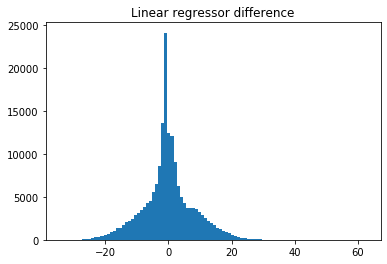

In [22]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [23]:
uif_out.reshape(-1,1).shape

(181440, 1)

In [24]:
sla[:10*36*72,:].shape

(25920, 11)

In [25]:
sla[10*36*72:11*36*72,:]

array([[3.2982371e+08, 4.3012157e+08, 4.3130067e+08, ..., 4.1856477e+08,
        4.1672803e+08, 4.1619171e+08],
       [3.2989165e+08, 4.3018813e+08, 4.3141155e+08, ..., 4.1880646e+08,
        4.1679670e+08, 4.1624694e+08],
       [3.2991754e+08, 4.3020230e+08, 4.3146352e+08, ..., 4.1902653e+08,
        4.1692646e+08, 4.1626794e+08],
       ...,
       [1.7091520e+09, 1.5555758e+09, 1.5599835e+09, ..., 1.5650232e+09,
        1.5602460e+09, 1.5549108e+09],
       [1.7200332e+09, 1.5640590e+09, 1.5681286e+09, ..., 1.5672682e+09,
        1.5620808e+09, 1.5563699e+09],
       [1.7308575e+09, 1.5723578e+09, 1.5760733e+09, ..., 1.5693187e+09,
        1.5637396e+09, 1.5576774e+09]], dtype=float32)

In [26]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72].reshape(36,72)

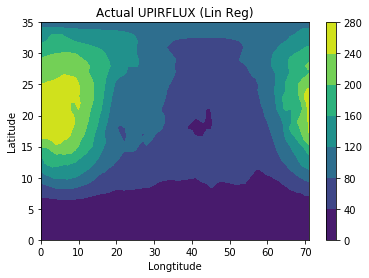

In [27]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

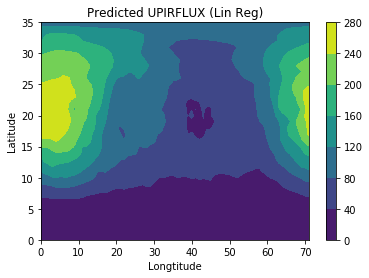

In [28]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

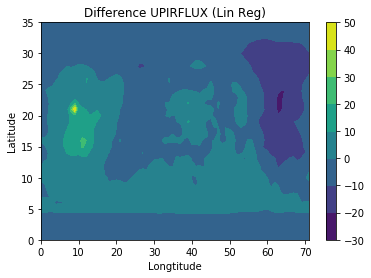

In [29]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

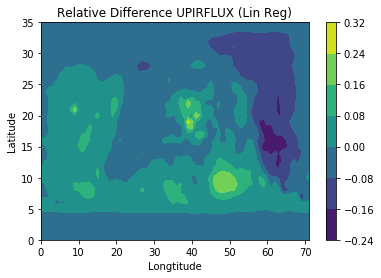

In [30]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

# Let's try random forest regressor:

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rfr1 = RandomForestRegressor()
rfr1.fit(sla[:10*36*72,:],uif_out[:10*36*72]) #training set
uif_rfr = rfr1.predict(sla[10*36*72:11*36*72,:]) 

rfr_mse = mean_squared_error(uif_out[10*36*72:11*36*72], uif_rfr) #test the model on a single day
rfr_rmse = np.sqrt(rfr_mse)
rfr_rmse 

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


3.8441431117485183

In [32]:
rfr_diff = uif_out[10*36*72:11*36*72] - uif_rfr

<function matplotlib.pyplot.show(*args, **kw)>

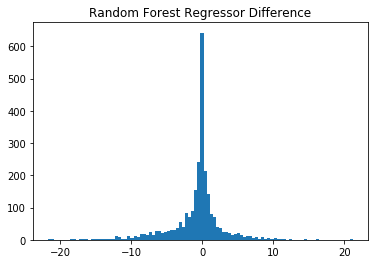

In [33]:
plt.hist(rfr_diff, bins = 100)
plt.title("Random Forest Regressor Difference")
plt.show #wow, much better!

In [34]:
real_out = uif_out[10*36*72:11*36*72].reshape(36,72)
pred_out = uif_rfr.reshape(36,72)

In [35]:
np.max(uif_out[10*36*72:11*36*72])

275.87045

In [36]:
np.array_equal(uif_rfr,pred_out.reshape(-1))

True

In [37]:
real_out.shape

(36, 72)

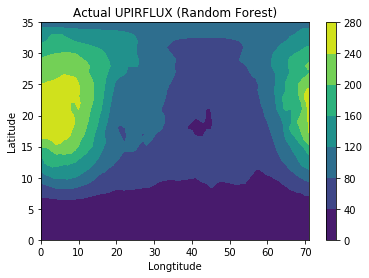

In [38]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

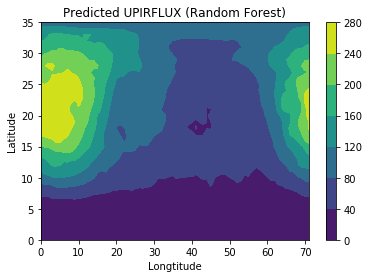

In [39]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

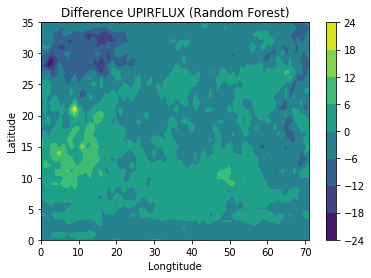

In [40]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

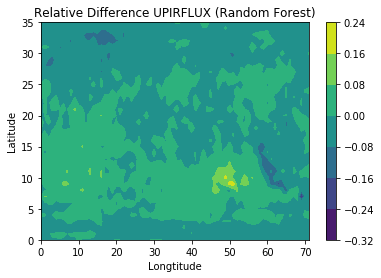

In [41]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Random Forest)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [42]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [43]:
real_out.shape

(36, 72)

In [44]:
rfr_int_err = int_err(uif_rfr, uif_out[10*36*72:11*36*72], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Random forest integration error:")
np.array(rfr_int_err)/(1.44e14) #larger...

Random forest integration error:


-0.4002368705905593

In [45]:
lin_int_err = int_err(uif_lin[10*36*72:11*36*72], uif_out[10*36*72:11*36*72], pd.DataFrame(uif_rfr), 3.39e6) #make sure the errors work by integrating a sphere's surface
print("Linear regression integration error:")
np.array(lin_int_err)/(1.44e14) #even larger...

Linear regression integration error:


-1.4346704954958274